In [89]:
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

DATA_RAW_PATH = "data/basura"
APP_FINAL_DATA_PATH = "src/data/final"

# Medicion Indice de Calidad de Limpieza

In [5]:
data_icl = pd.read_csv(os.path.join(DATA_RAW_PATH, "medicion-icl-por-nivel.csv"), sep=";")
data_icl.info()
data_icl.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Medicion                       80 non-null     int64 
 1   Periodo                        80 non-null     object
 2   Estratificacion_geografica     80 non-null     object
 3   Comunas                        80 non-null     object
 4   Indice_de_Calidad_de_Limpieza  80 non-null     object
dtypes: int64(1), object(4)
memory usage: 3.2+ KB


,Medicion,Periodo,Estratificacion_geografica,Comunas,Indice_de_Calidad_de_Limpieza
23,3,Febrero-Marzo_2019,Zona_7,"3, 4","72,6"


In [6]:
data_icl.rename(mapper=str.lower, axis="columns", inplace=True)

In [7]:
data_icl.sample()

,medicion,periodo,estratificacion_geografica,comunas,indice_de_calidad_de_limpieza
14,2,Octubre-Noviembre_2018,Zona_6,"5, 6, 7","61,8"


In [8]:
data_icl.periodo.value_counts(dropna=False, normalize=True)

Febrero-Marzo_2018        0.1
Octubre-Noviembre_2018    0.1
Febrero-Marzo_2019        0.1
Octubre-Noviembre_2019    0.1
Febrero-Marzo_2020        0.1
Octubre-Noviembre_2020    0.1
Febrero-Marzo_2021        0.1
Octubre-Noviembre_2021    0.1
Febrero-Marzo_2022        0.1
Octubre-Noviembre_2022    0.1
Name: periodo, dtype: float64

In [9]:
data_icl.estratificacion_geografica.value_counts(dropna=False, normalize=True)

Ciudad    0.125
Zona_1    0.125
Zona_2    0.125
Zona_3    0.125
Zona_4    0.125
Zona_5    0.125
Zona_6    0.125
Zona_7    0.125
Name: estratificacion_geografica, dtype: float64

In [10]:
data_icl.comunas.value_counts(dropna=False, normalize=True)

1, 2,3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15    0.125
1                                                   0.125
2, 13, 14                                           0.125
11, 12, 15                                          0.125
9, 10                                               0.125
8                                                   0.125
5, 6, 7                                             0.125
3, 4                                                0.125
Name: comunas, dtype: float64

In [16]:
data_icl.indice_de_calidad_de_limpieza.replace("S/D", None, inplace=True)
data_icl.indice_de_calidad_de_limpieza = pd.to_numeric(data_icl.indice_de_calidad_de_limpieza.str.replace(",", "."))
data_icl.indice_de_calidad_de_limpieza.describe(percentiles=[.1,.2,.6,.7,.95,.99])

count    73.000000
mean     64.113014
std       7.903094
min      45.650000
10%      55.210000
20%      57.700000
50%      62.400000
60%      64.910000
70%      69.060000
95%      78.720000
99%      80.930000
max      81.650000
Name: indice_de_calidad_de_limpieza, dtype: float64

Como se relacionan las estratificaciones con las comunas?

In [21]:
data_icl.groupby(["estratificacion_geografica", "comunas"]).size()\
    .unstack().fillna(0)\
    .style.background_gradient(cmap="Blues", axis=1)
## Salvo los valores de Ciudad que son para todas las comunas, las estratificaciones son conjuntos de comunas

comunas,1,"1, 2,3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15","11, 12, 15","2, 13, 14","3, 4","5, 6, 7",8,"9, 10"
estratificacion_geografica,,,,,,,,
Ciudad,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Zona_1,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Zona_2,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000
Zona_3,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Zona_4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
Zona_5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000
Zona_6,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000
Zona_7,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000


In [22]:
# drop valores de ciudad total, porque me interesa la mayor granularidad posible
data_icl = data_icl[data_icl.estratificacion_geografica != "Ciudad"]


In [25]:
# unpack de la columna de comunas para tener una fila por comuna
data_icl = data_icl.join(data_icl.comunas.str.split(",", expand=True).stack().reset_index(level=1, drop=True).rename("comuna"))
data_icl.drop(columns=["comunas"], inplace=True)

In [ ]:
data_icl.sample()

,medicion,periodo,estratificacion_geografica,indice_de_calidad_de_limpieza,comuna
62,8,Octubre-Noviembre_2021,Zona_6,53.3,7


## Qué quiero medir?

- Tendencias en el índice de Calidad de Limpieza (tomando 2021 y 2022) -> ver si cayó o aumentó el ICL
- Valores estáticos para 2022


### Tendencias en ICL

In [28]:
# me quedo con periodos de 2021 a 2022
data_icl["year"] = data_icl.periodo.apply(lambda x: x.split("_")[-1])
data_icl.year.value_counts(dropna=False)

2018    30
2019    30
2020    30
2021    30
2022    30
Name: year, dtype: int64

In [32]:
tendencias_icl = data_icl[data_icl.year.isin(["2021", "2022"])]
tendencias_icl["semestre"] = tendencias_icl.periodo.apply(lambda periodo: 1 if "febrero" in periodo.lower() else 2) # hay 2 mediciones, una en febrero-marzo y otra en octubre-noviembre
tendencias_icl[["year", "semestre", "comuna", "indice_de_calidad_de_limpieza", "periodo"]]

/tmp/ipykernel_840495/2801793465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tendencias_icl["semestre"] = tendencias_icl.periodo.apply(lambda periodo: 1 if "febrero" in periodo.lower() else 2) # hay 2 mediciones, una en febrero-marzo y otra en octubre-noviembre


,year,semestre,comuna,indice_de_calidad_de_limpieza,periodo
49,2021,1,1,59.95,Febrero-Marzo_2021
50,2021,1,2,66.70,Febrero-Marzo_2021
50,2021,1,13,66.70,Febrero-Marzo_2021
50,2021,1,14,66.70,Febrero-Marzo_2021
51,2021,1,11,57.70,Febrero-Marzo_2021
51,2021,1,12,57.70,Febrero-Marzo_2021
51,2021,1,15,57.70,Febrero-Marzo_2021
52,2021,1,9,59.64,Febrero-Marzo_2021
52,2021,1,10,59.64,Febrero-Marzo_2021
53,2021,1,8,60.43,Febrero-Marzo_2021


In [47]:
tendencias_icl.comuna = pd.to_numeric(tendencias_icl.comuna)

/tmp/ipykernel_840495/696494640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tendencias_icl.comuna = pd.to_numeric(tendencias_icl.comuna)


In [56]:
tendencias_icl.sample()

,medicion,periodo,estratificacion_geografica,indice_de_calidad_de_limpieza,comuna,year,semestre
78,10,Octubre-Noviembre_2022,Zona_6,61.45,6,2022,2


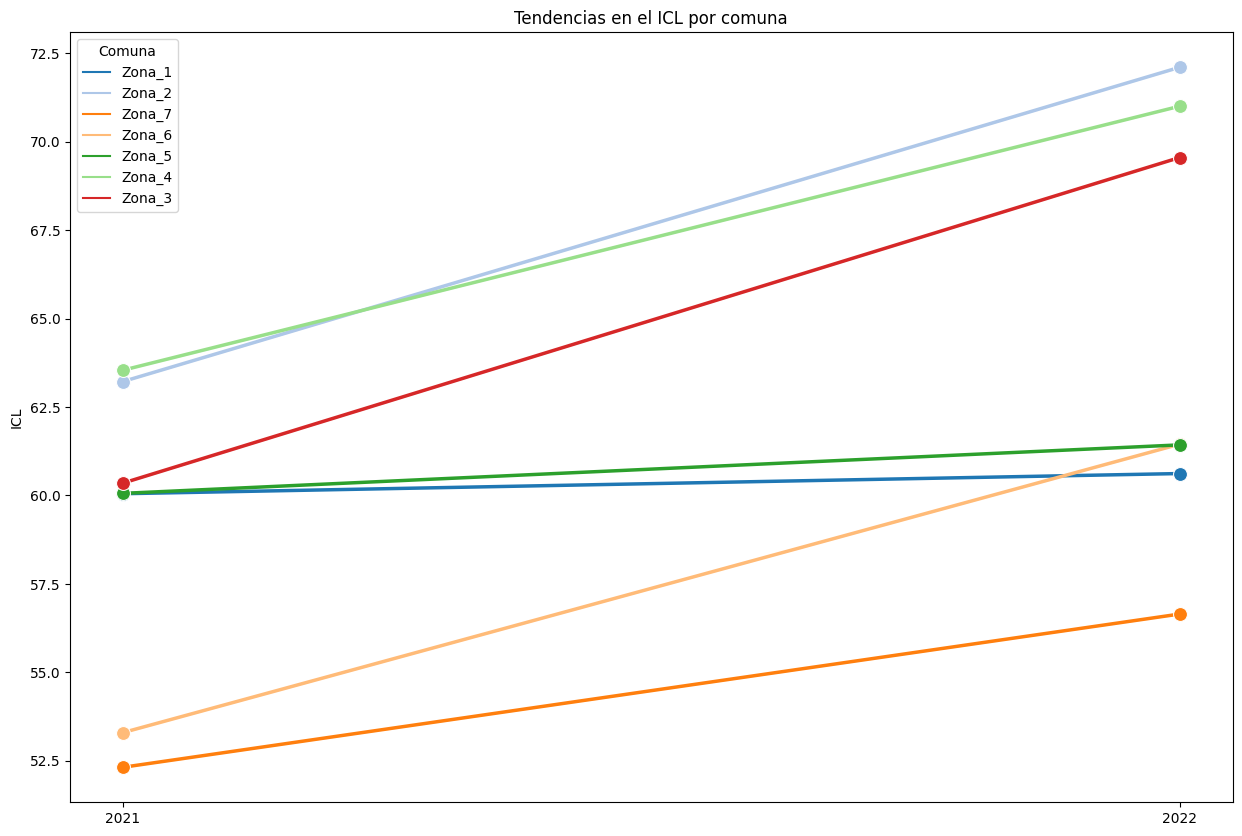

In [65]:
# plot variaciones en el ICL para cada comuna
fig, ax = plt.subplots(figsize=(15, 10))
# put a marker on each observation point
sns.lineplot(
    data=tendencias_icl[tendencias_icl.semestre == 2].sort_values("comuna"),
    x="year",
    y="indice_de_calidad_de_limpieza",
    hue="estratificacion_geografica",
    linewidth=2.5, ax=ax,
    palette="tab20",
    marker="o", markersize=10,
)

## Todas las tendencias son positivas
plt.ylabel("ICL")
plt.xlabel("")
plt.legend(title="Comuna")
plt.title("Tendencias en el ICL por comuna")

plt.savefig("visuals/basura/tendencias_icl_estratificacion_geografica_sem2interanual.png")

/tmp/ipykernel_840495/3402285680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tendencias_icl["semestre_label"] = tendencias_icl.year.astype(str) + " - S" + tendencias_icl.semestre.astype(str)


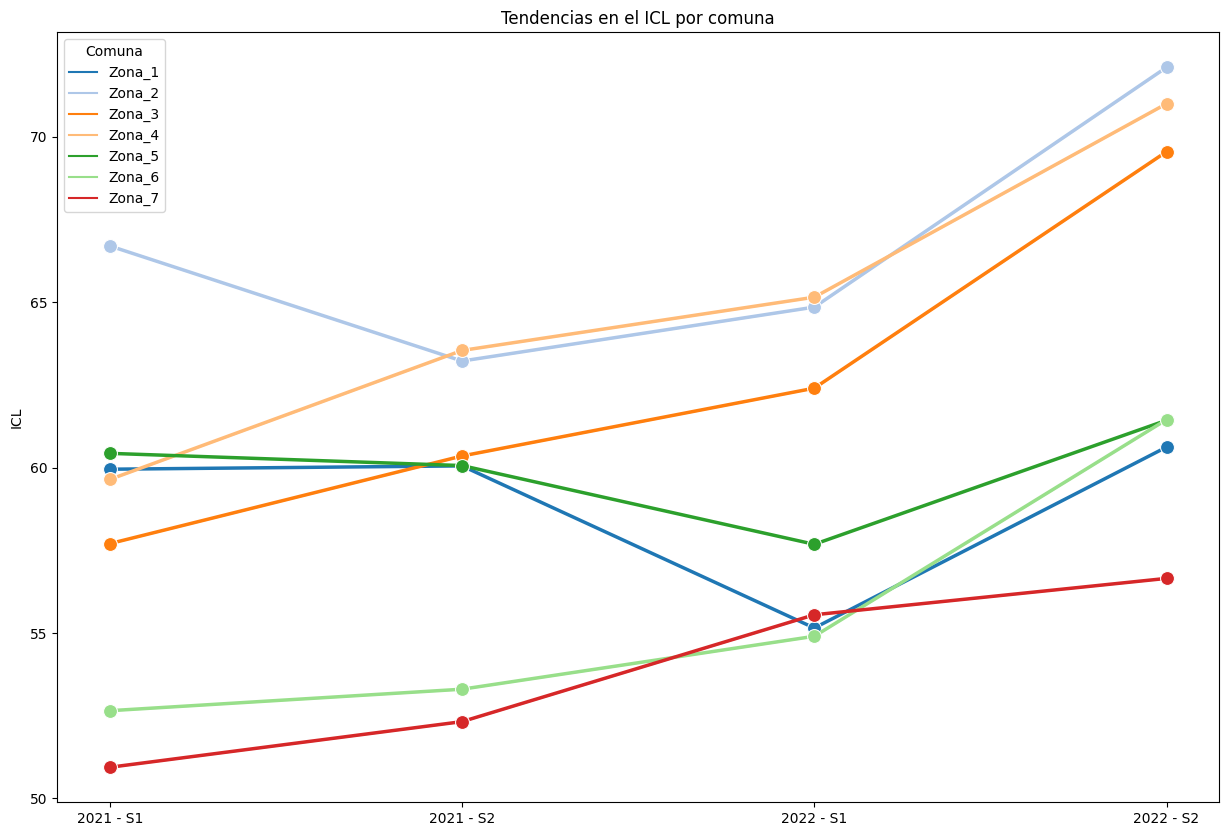

In [68]:
# plot variaciones en el ICL para cada comuna
fig, ax = plt.subplots(figsize=(15, 10))
# put a marker on each observation point

tendencias_icl["semestre_label"] = tendencias_icl.year.astype(str) + " - S" + tendencias_icl.semestre.astype(str)

sns.lineplot(
    data=tendencias_icl.sort_values(["estratificacion_geografica", "semestre_label"]),
    x="semestre_label",
    y="indice_de_calidad_de_limpieza",
    hue="estratificacion_geografica",
    linewidth=2.5, ax=ax,
    palette="tab20",
    marker="o", markersize=10,
)

## Todas las tendencias son positivas
plt.ylabel("ICL")
plt.xlabel("")
plt.legend(title="Comuna")
plt.title("Tendencias en el ICL por comuna")

plt.savefig("visuals/basura/tendencias_icl_estratificacion_geografica.png")

In [70]:
tendencias_icl[tendencias_icl.comuna == 3]

,medicion,periodo,estratificacion_geografica,indice_de_calidad_de_limpieza,comuna,year,semestre,semestre_label
55,7,Febrero-Marzo_2021,Zona_7,50.94,3,2021,1,2021 - S1
63,8,Octubre-Noviembre_2021,Zona_7,52.32,3,2021,2,2021 - S2
71,9,Febrero-Marzo_2022,Zona_7,55.55,3,2022,1,2022 - S1
79,10,Octubre-Noviembre_2022,Zona_7,56.65,3,2022,2,2022 - S2


In [76]:
agged_tendencias_icl = tendencias_icl\
                            .sort_values("semestre_label")\
                            .groupby(["comuna"])\
                            .apply(lambda x: x.indice_de_calidad_de_limpieza.iloc[-1] - x.indice_de_calidad_de_limpieza.iloc[0])
agged_tendencias_icl = agged_tendencias_icl.to_frame(name="variacion_total_icl")
agged_tendencias_icl.reset_index(inplace=True)
agged_tendencias_icl

,comuna,variacion_total_icl
0,1,0.67
1,2,5.40
2,3,5.71
3,4,5.71
4,5,8.80
5,6,8.80
6,7,8.80
7,8,1.00
8,9,11.36
9,10,11.36


In [82]:
#### Add last 2022 observation
last_observation = tendencias_icl[tendencias_icl.semestre_label == "2022 - S2"][["comuna", "indice_de_calidad_de_limpieza"]]
last_observation.rename(columns={"indice_de_calidad_de_limpieza": "icl_2022"}, inplace=True)
agged_tendencias_icl = agged_tendencias_icl.merge(last_observation, on="comuna", how="left")

#### Append GeoJSON shapes to data

In [78]:
import geopandas as gpd

In [79]:
comunas = gpd.read_file("res/comunas-geojson.json", driver="GeoJSON")
comunas.sample()

,ID,OBJETO,COMUNAS,BARRIOS,PERIMETRO,AREA,geometry
7,15,LIMITE COMUNAL,13.0,BELGRANO - COLEGIALES - NUÑEZ,26198.826953,1.471321e+07,"MULTIPOLYGON (((-58.44033 -34.54022, -58.44032..."


In [86]:
agged_tendencias_icl = agged_tendencias_icl.merge(comunas[["COMUNAS", "geometry"]], left_on="comuna", right_on="COMUNAS", how="left").drop(columns=["COMUNAS"])
agged_tendencias_icl.sample()

,comuna,variacion_total_icl,icl_2022,geometry
3,4,5.71,56.65,"MULTIPOLYGON (((-58.38864 -34.63373, -58.38864..."


<Axes: >

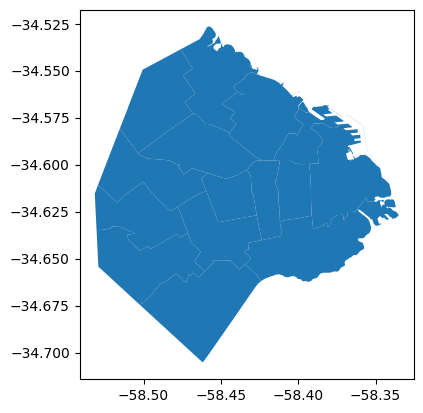

In [88]:
# convert to geodataframe and save as geojson
agged_tendencias_icl = gpd.GeoDataFrame(agged_tendencias_icl, geometry="geometry")
agged_tendencias_icl.plot()

<Axes: >

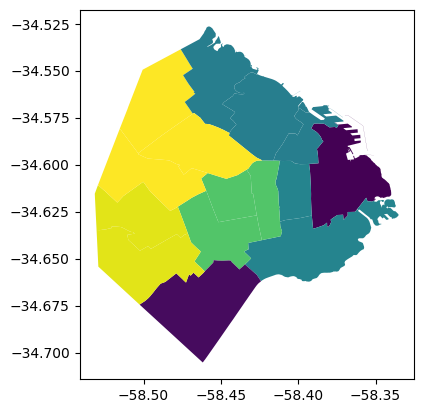

In [90]:
agged_tendencias_icl.plot(column="variacion_total_icl")

In [91]:
agged_tendencias_icl.to_file(os.path.join(APP_FINAL_DATA_PATH, "basura_tendencias_icl.geojson"), driver="GeoJSON")

In [92]:
# save to out-of-app data folder
agged_tendencias_icl.to_file(os.path.join("data/final", "basura_tendencias_icl.geojson"), driver="GeoJSON")

# Actas

In [129]:
actas_comuna = pd.read_csv(os.path.join(DATA_RAW_PATH, "actas_por_comuna.csv"), sep=";")
actas_motivo = pd.read_csv(os.path.join(DATA_RAW_PATH, "actas_por_motivo.csv"), sep=";", encoding="latin1")
actas_rubro = pd.read_csv(os.path.join(DATA_RAW_PATH, "actas_por_rubro.csv"), sep=";", encoding="latin1")
fiscalizaciones_comuna = pd.read_csv(os.path.join(DATA_RAW_PATH, "fiscalizaciones_por_comuna.csv"), sep=";", encoding="latin1")
fiscalizaciones_rubro = pd.read_csv(os.path.join(DATA_RAW_PATH, "fiscalizaciones_por_rubro.csv"), sep=";", encoding="latin1")
cumplimiento_med_nivel = pd.read_csv(os.path.join(DATA_RAW_PATH, "cumplimiento-por-medicion-y-nivel.csv"), sep=";", encoding="latin1")

cumplimiento_med_nivel.sample()


,Medicion,Periodo,Estratificacion_geografica,Comunas,Criterio,Porcentaje_de_cumplimiento
169,5,Febrero-Marzo_2020,Zona_1,1,Grafitis_pegatinas_y_otros,83%


In [130]:
cumplimiento_med_nivel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Medicion                    400 non-null    int64 
 1   Periodo                     400 non-null    object
 2   Estratificacion_geografica  400 non-null    object
 3   Comunas                     400 non-null    object
 4   Criterio                    400 non-null    object
 5   Porcentaje_de_cumplimiento  400 non-null    object
dtypes: int64(1), object(5)
memory usage: 18.9+ KB


In [131]:
cumplimiento_med_nivel.rename(mapper=str.lower, axis=1, inplace=True)

In [132]:
cumplimiento_med_nivel.sample()

,medicion,periodo,estratificacion_geografica,comunas,criterio,porcentaje_de_cumplimiento
300,8,Octubre-Noviembre_2021,Zona_4,"9, 10",Mobiliario_de_higiene_urbana,95%


In [133]:
cumplimiento_med_nivel.criterio.value_counts(dropna=False)

Mobiliario_de_higiene_urbana    80
Disposicion_de_residuos         80
Heces_caninas                   80
Limpieza_de_veredas_y_calles    80
Grafitis_pegatinas_y_otros      80
Name: criterio, dtype: int64

In [134]:
cumplimiento_med_nivel = cumplimiento_med_nivel[cumplimiento_med_nivel.estratificacion_geografica != "Ciudad"]

In [138]:
cumplimiento_med_nivel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350 entries, 5 to 399
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   medicion                    350 non-null    int64 
 1   periodo                     350 non-null    object
 2   estratificacion_geografica  350 non-null    object
 3   comunas                     350 non-null    object
 4   criterio                    350 non-null    object
 5   porcentaje_de_cumplimiento  350 non-null    object
dtypes: int64(1), object(5)
memory usage: 27.2+ KB


In [135]:
cumplimiento_med_nivel.head()

,medicion,periodo,estratificacion_geografica,comunas,criterio,porcentaje_de_cumplimiento
5,1,Febrero-Marzo_2018,Zona_1,1,Mobiliario_de_higiene_urbana,80%
6,1,Febrero-Marzo_2018,Zona_1,1,Disposicion_de_residuos,85%
7,1,Febrero-Marzo_2018,Zona_1,1,Heces_caninas,67%
8,1,Febrero-Marzo_2018,Zona_1,1,Limpieza_de_veredas_y_calles,45%
9,1,Febrero-Marzo_2018,Zona_1,1,Grafitis_pegatinas_y_otros,55%


In [140]:
# unpack comunas to have one value for each row
cumplimiento_med_nivel = cumplimiento_med_nivel.join(cumplimiento_med_nivel.comunas.str.split(",", expand=True).stack().reset_index(level=1, drop=True).rename("comuna")).reset_index(drop=True)

In [147]:
# preprocess porcentaje de cumplimiento
cumplimiento_med_nivel.replace({
    "porcentaje_de_cumplimiento": {
        "S/D":None
    }
}, inplace=True)

In [150]:
cumplimiento_med_nivel.porcentaje_de_cumplimiento = pd.to_numeric(cumplimiento_med_nivel.porcentaje_de_cumplimiento.str.replace("%", "").str.strip()) / 100 # normalize to be 0 to 1

In [151]:
cumplimiento_med_nivel.sample()

,medicion,periodo,estratificacion_geografica,comunas,criterio,porcentaje_de_cumplimiento,comuna
202,3,Febrero-Marzo_2019,Zona_6,"5, 6, 7",Mobiliario_de_higiene_urbana,0.76,7


In [153]:
print("Periodos cubiertos:")
print(cumplimiento_med_nivel.periodo.value_counts(dropna=False))
# keep only 2021 (data ranges from '18 to '21)
cumplimiento_med_nivel["year"] = cumplimiento_med_nivel.periodo.apply(lambda s: s.split("_")[-1]).astype(int)
cumplimiento_med_nivel = cumplimiento_med_nivel[cumplimiento_med_nivel.year == 2021]

Periodos cubiertos:
Febrero-Marzo_2018        75
Octubre-Noviembre_2018    75
Febrero-Marzo_2019        75
Octubre-Noviembre_2019    75
Febrero-Marzo_2020        75
Octubre-Noviembre_2020    75
Febrero-Marzo_2021        75
Octubre-Noviembre_2021    75
Febrero-Marzo_2022        75
Octubre-Noviembre_2022    75
Name: periodo, dtype: int64


In [157]:
cumplimiento_med_nivel.criterio = cumplimiento_med_nivel.criterio.str.replace("_", " ")

/tmp/ipykernel_840495/3960205342.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumplimiento_med_nivel.criterio = cumplimiento_med_nivel.criterio.str.replace("_", " ")


In [158]:
cumplimiento_med_nivel.sample()

,medicion,periodo,estratificacion_geografica,comunas,criterio,porcentaje_de_cumplimiento,comuna,year
596,8,Octubre-Noviembre_2021,Zona_7,"3, 4",Limpieza de veredas y calles,0.25,3,2021


In [177]:
cumplimiento_med_nivel.groupby("criterio").porcentaje_de_cumplimiento.describe()\
    .style.background_gradient(cmap="Blues")

,count,mean,std,min,25%,50%,75%,max
criterio,,,,,,,,
Disposicion de residuos,30.000000,0.919333,0.023034,0.850000,0.910000,0.920000,0.940000,0.950000
Grafitis pegatinas y otros,30.000000,0.560333,0.092717,0.380000,0.530000,0.550000,0.600000,0.770000
Heces caninas,30.000000,0.250000,0.112280,0.130000,0.200000,0.210000,0.250000,0.630000
Limpieza de veredas y calles,30.000000,0.390667,0.102719,0.250000,0.302500,0.360000,0.460000,0.550000
Mobiliario de higiene urbana,30.000000,0.812667,0.087136,0.700000,0.750000,0.770000,0.890000,0.950000


No hay sustancial amplitud en los datos que amerite dividir en quintiles para marcar una diferencia clara. Por eso vamos a mostrar directamente el porcentaje de cumplimiento.

In [178]:
# Por las dudas, dejo el ejercicio de computar un score, aunque basado en tercios de la distribucion para evitar el impacto de bins duplicados (separación exceisvamente granular)
# assign a score between 1 and 5 depending on the percentage of cumplimiento for each criterio
# the score is computed according to the quintile of the percentage of cumplimiento distribution for each criterio
cumplimiento_med_nivel["cumplimiento_score"] = cumplimiento_med_nivel.groupby("criterio").porcentaje_de_cumplimiento.transform(lambda x: pd.qcut(x, 3, labels=False)+1)
cumplimiento_med_nivel.groupby("criterio").cumplimiento_score.value_counts(dropna=False).to_frame()

/tmp/ipykernel_840495/1851525728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumplimiento_med_nivel["cumplimiento_score"] = cumplimiento_med_nivel.groupby("criterio").porcentaje_de_cumplimiento.transform(lambda x: pd.qcut(x, 3, labels=False)+1)


cumplimiento_score
criterio                     cumplimiento_score                    
Disposicion de residuos      1                                   14
                             2                                   13
                             3                                    3
Grafitis pegatinas y otros   1                                   18
                             3                                   10
                             2                                    2
Heces caninas                1                                   13
                             3                                   10
                             2                                    7
Limpieza de veredas y calles 1                                   13
                             3                                    9
                             2                                    8
Mobiliario de higiene urbana 1                                   11
                             3                                   10
                             2                                    9

In [181]:
cumplimiento_med_nivel.comuna = cumplimiento_med_nivel.comuna.astype(int)

/tmp/ipykernel_840495/1793745678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumplimiento_med_nivel.comuna = cumplimiento_med_nivel.comuna.astype(int)


<Axes: >

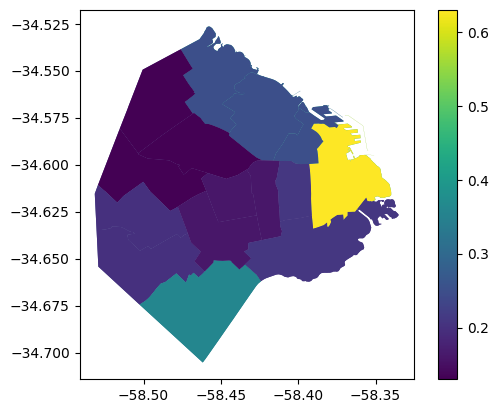

In [183]:
cumplimiento_med_nivel = cumplimiento_med_nivel.merge(comunas[["COMUNAS", "geometry"]], left_on="comuna", right_on="COMUNAS", how="left").drop(columns=["COMUNAS"])
cumplimiento_med_nivel = gpd.GeoDataFrame(cumplimiento_med_nivel, geometry="geometry")
cumplimiento_med_nivel[cumplimiento_med_nivel.criterio == "Heces caninas"].plot(column="porcentaje_de_cumplimiento", legend=True)

In [184]:
cumplimiento_med_nivel.sample()

,medicion,periodo,estratificacion_geografica,comunas,criterio,porcentaje_de_cumplimiento,comuna,year,cumplimiento_score,geometry
110,8,Octubre-Noviembre_2021,Zona_4,"9, 10",Mobiliario de higiene urbana,0.95,9,2021,3,"MULTIPOLYGON (((-58.50252 -34.67451, -58.50253..."


In [185]:
cumplimiento_med_nivel.to_file(os.path.join(APP_FINAL_DATA_PATH, "basura_cumplimiento_med_nivel.geojson"), driver="GeoJSON")